# Lab 7: Event Selection Optimization

## William Olsen, partners with Jennifer Vo

Previously, we explored what the Higgs Boson is and some of it's properties (Lab 5).  In this lab we will explore how we can perform event selections in order to increase the significance of our Higgs measurement.  We had previously found that the significance for the discovery of the Higgs was quite low when using the whole data set - however through a series of data cuts we can optimize this significance and increase our confidence regarding the discovery of the Higgs Boson.  We will be using simulated data from the Large Haderon Collider with a transverse momentum between 1000 and 1200.

Before loading our data, let's recall that we have two sets of data: 100000 Higgs Boson simulated events, of which we have an expected yield of 50 and 100000 QCD background simulated events, of which we have an expected yield of 2000.  We also found that our QCD background is Poisson distributed with a parameter equal to the current expected yield of the QCD simulated data after a series of possible data cuts.  With these values, we can construct ratios to determine the percentage of simulated data that would correspond to a true lab event for both simulated sets of data: the Higgs set and the QCD set.

$$R_{higgs} = \frac{50}{100000} = 0.0005$$

$$R_{qcd} = \frac{2000}{100000} = 0.02$$

With these ratios if we now wanted to determine the expected yield of true lab measurements after a split we can.  We can calculate the expected yields for our Higgs events and our QCD events using the following formulas:

$$yield_{higgs} = N_{higgs}*R_{higgs}$$

$$yield_{qcd} = N_{qcd}*R_{qcd}$$

Where $N_{higgs}$ and $N_{qcd}$ are the number of Higgs and QCD simulated events, respectively, after a series of data cuts.

Lets begin by loading our data so we can explore optimizing our discovery sensitivity:

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pickle

# general graphing setup
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
# open the file of interest, and use pickle loading
higgsfile = open ("higgs_100000_pt_1000_1200.pkl",'rb')
higgsdata = pickle.load(higgsfile)
qcdfile = open ("qcd_100000_pt_1000_1200.pkl",'rb')
qcddata = pickle.load(qcdfile)

### Problem 1

Now that we have loaded our data, let's make a stacked histogram of the feature variable mass.

In [16]:
def plot_stacked_hist(feature):
    bins = 100
    fs = 18
    
    # get the data
    feature_qcddata = qcddata[f'{feature}']
    feature_higgsdata = higgsdata[f'{feature}']
    feature_data = [feature_qcddata, feature_higgsdata]
    
    # plot
    plt.hist(feature_data, bins=bins, stacked=True, label=['QCD Background counts', 'Higgs counts']) # add density=True for probability density
    plt.title('Stacked QCD background counts and Higgs counts', fontsize=fs)
    plt.xlabel(f' {feature}', fontsize=fs)
    plt.ylabel('Event counts', fontsize=fs)
    plt.tick_params(labelsize=fs)
    plt.legend()
    
    plt.show()

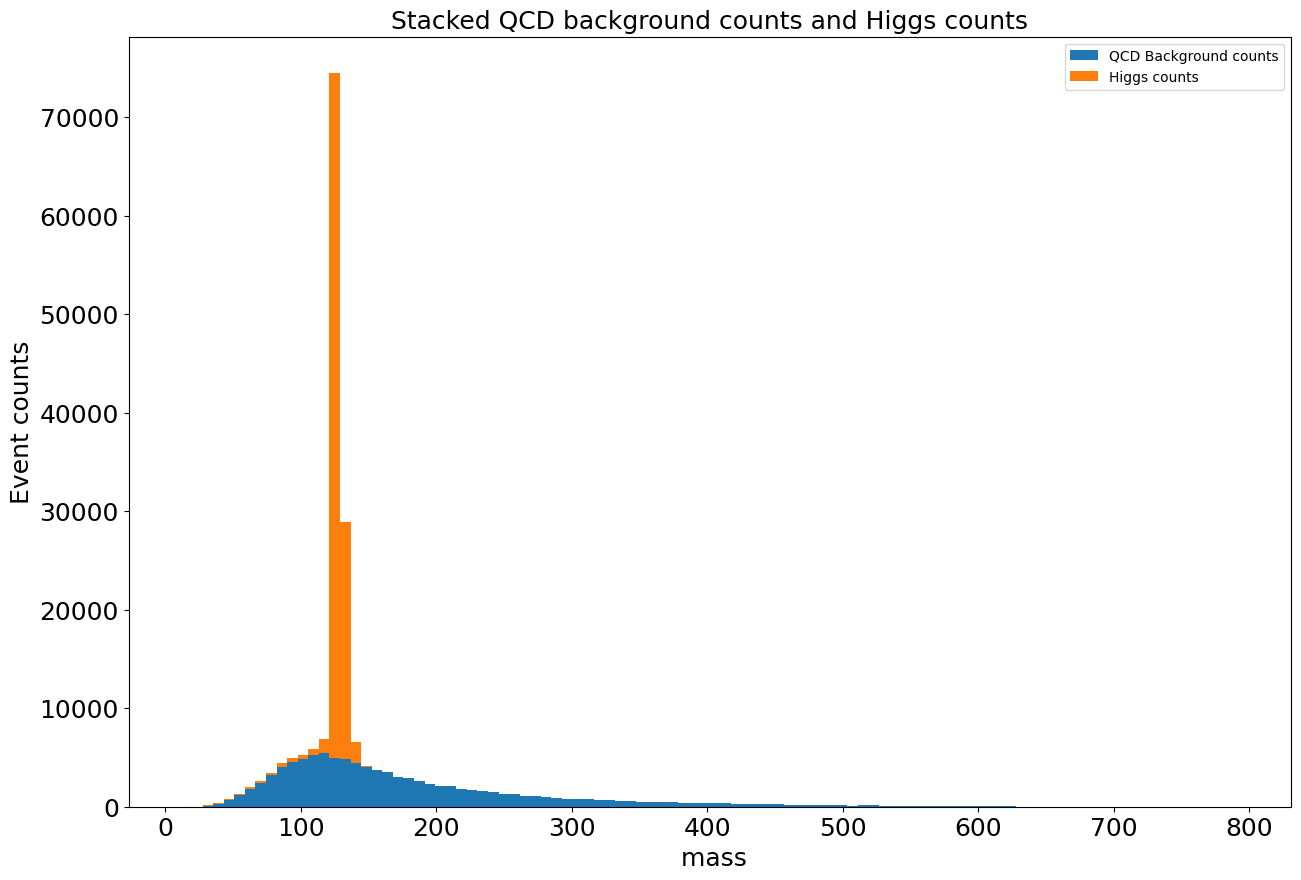

In [17]:
plot_stacked_hist('mass')

We can see from above that the Higgs data is closely grouped around a small range of values while the QCD Background events are more spread out over different mass values.  This is to our expectation as the Higgs Boson has a specific mass.

Now that we have visuallized this stacked histogram, let's calculate the expected significance associated with the Higgs Boson without any event selections.  As previously stated, our background is Poisson distirbuted so we will use Poisson statistics for the significance calculation.  Let's calculate this significance: